This notebook is intended to be an example of how to perform linear regression with either Pytorch or sklearn

In [5]:
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

# I will use this simple dataset to perform regression analysis on

This dataset was taken from the following website:
https://online.stat.psu.edu/stat462/node/101/

In [3]:
poverty = pd.read_csv('/srv/home/jmckinley/work/pytorch/basic_tests/poverty.csv')

In [4]:
poverty.head()

,Location,PovPct,Brth15to17,Brth18to19,ViolCrime,TeenBrth
0,Alabama,20.1,31.5,88.7,11.2,54.5
1,Alaska,7.1,18.9,73.7,9.1,39.5
2,Arizona,16.1,35.0,102.5,10.4,61.2
3,Arkansas,14.9,31.6,101.7,10.4,59.9
4,California,16.7,22.6,69.1,11.2,41.1


Text(0, 0.5, 'TeenBrth')

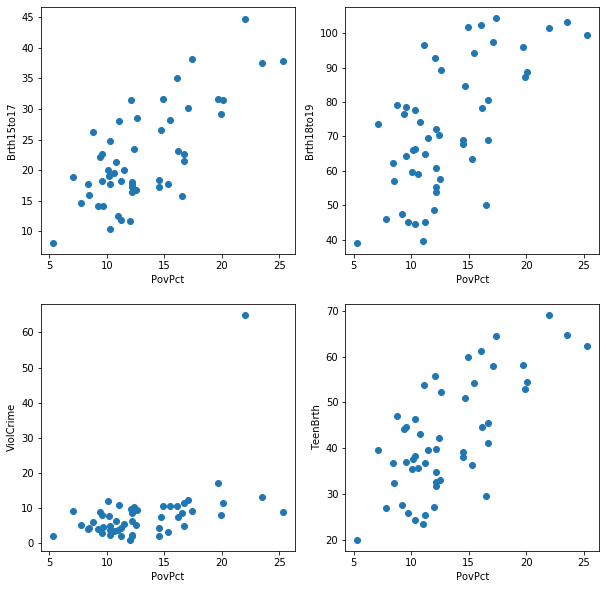

In [140]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

axs[0,0].scatter(poverty['PovPct'], poverty['Brth15to17'], label='Brth15to17')
axs[0,1].scatter(poverty['PovPct'], poverty['Brth18to19'], label='Brth18to19')
axs[1,0].scatter(poverty['PovPct'], poverty['ViolCrime'], label='ViolCrime')
axs[1,1].scatter(poverty['PovPct'], poverty['TeenBrth'], label='TeenBrth')

axs[0,0].set_xlabel('PovPct')
axs[0,1].set_xlabel('PovPct')
axs[1,0].set_xlabel('PovPct')
axs[1,1].set_xlabel('PovPct')
axs[0,0].set_ylabel('Brth15to17')
axs[0,1].set_ylabel('Brth18to19')
axs[1,0].set_ylabel('ViolCrime')
axs[1,1].set_ylabel('TeenBrth')

Note: I have arbitrarily chosen the 'PovPct' and 'Brth15to17' to perform linear regression on. This is not to suggest that one of these values is easier to predict on than others.

# First let's try out sklearn

In [8]:
from sklearn.linear_model import LinearRegression

### Instantiate the LinearRegression module

In [9]:
sk_model = LinearRegression()

### Reshape the data to make sklearn happy

In [27]:
tmp_x = poverty['PovPct'].to_numpy()
tmp_x = tmp_x.reshape(-1, 1)
tmp_y = poverty['Brth15to17'].to_numpy()
tmp_y = tmp_y.reshape(-1, 1)

In [29]:
tmp_x.shape

(51, 1)

In [30]:
tmp_y.shape

(51, 1)

### Now fit the data

In [31]:
sk_model.fit(tmp_x, tmp_y)

LinearRegression()

### Get the R^2 value

In [126]:
r_sq_sklr = sk_model.score(tmp_x, tmp_y)
print('coefficient of determination:', r_sq_sklr)

coefficient of determination: 0.5333279627871967


### Can also get the slope and the intercept

In [35]:
print('intercept:', sk_model.intercept_)
print('slope:', sk_model.coef_)

line_fit_y = tmp_x*sk_model.coef_ + sk_model.intercept_

intercept: [4.26729284]
slope: [[1.37334539]]


### Visualize the results

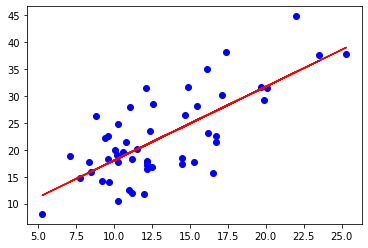

In [39]:
plt.scatter(tmp_x, tmp_y, c='b')
plt.plot(tmp_x, line_fit_y, c='r')

# Now let's try a simple neural network

For this example I heavily followed this article: https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

In [50]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### First define the data (note: wanted dtype=np.float32)

In [64]:
x_train = poverty['PovPct'].to_numpy(dtype=np.float32)
x_train = x_train.reshape(-1, 1)
y_train = poverty['Brth15to17'].to_numpy(dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [65]:
x_train.shape

(51, 1)

In [100]:
x_train[0]

array([20.1], dtype=float32)

### Next define the model

In [87]:
class linearRegression(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        #Now define features of the NN
        self.linear = torch.nn.Linear(inputSize, outputSize)
    
    def forward(self, x):
        # Now define what a forward pass looks like
        out = self.linear(x)
        #print(out)
        return out

### Define some parameters for training

In [141]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.0001 
epochs = 500

### Instantiate the model

In [142]:
lr = linearRegression(inputDim, outputDim)

In [143]:
# Can tie this to a GPU if available
if torch.cuda.is_available():
    lr.cuda()

### Set loss criteria and optimization algorithm

In [144]:
# Now define the loss criteria
criterion = torch.nn.MSELoss()
#Next define the optimization algorithm
optimizer = torch.optim.SGD(lr.parameters(), lr=learningRate)

### Now train the model

In [145]:
for epoch in range(epochs):
    #Convert the inputs and labels to Variables
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))
    
    #Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to acummulate gradients
    optimizer.zero_grad()
    
    #get output from model given the inputs
    outputs = lr(inputs)
    
    #Compute the loss for the predicted output
    loss = criterion(outputs, labels)
    #print('epoch:',epoch,'\tloss:',loss)
    
    #Now compute the gradients w.r.t. parameters
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    #if(epoch == 5):
    #    break

epoch 0, loss 160.91172790527344
epoch 1, loss 151.2422637939453
epoch 2, loss 142.29710388183594
epoch 3, loss 134.02200317382812
epoch 4, loss 126.36676788330078
epoch 5, loss 119.28495025634766
epoch 6, loss 112.73363494873047
epoch 7, loss 106.67304992675781
epoch 8, loss 101.06643676757812
epoch 9, loss 95.87979888916016
epoch 10, loss 91.0816879272461
epoch 11, loss 86.64298248291016
epoch 12, loss 82.53675079345703
epoch 13, loss 78.73811340332031
epoch 14, loss 75.22401428222656
epoch 15, loss 71.97314453125
epoch 16, loss 68.96578216552734
epoch 17, loss 66.18368530273438
epoch 18, loss 63.60997009277344
epoch 19, loss 61.22905349731445
epoch 20, loss 59.0264778137207
epoch 21, loss 56.988895416259766
epoch 22, loss 55.10393524169922
epoch 23, loss 53.36015701293945
epoch 24, loss 51.747005462646484
epoch 25, loss 50.25467300415039
epoch 26, loss 48.874141693115234
epoch 27, loss 47.59700393676758
epoch 28, loss 46.415523529052734
epoch 29, loss 45.32254409790039
epoch 30, los

epoch 254, loss 31.806888580322266
epoch 255, loss 31.806808471679688
epoch 256, loss 31.80672264099121
epoch 257, loss 31.806642532348633
epoch 258, loss 31.806560516357422
epoch 259, loss 31.806474685668945
epoch 260, loss 31.806394577026367
epoch 261, loss 31.806310653686523
epoch 262, loss 31.80622673034668
epoch 263, loss 31.806148529052734
epoch 264, loss 31.806062698364258
epoch 265, loss 31.805978775024414
epoch 266, loss 31.80589485168457
epoch 267, loss 31.80581283569336
epoch 268, loss 31.80573272705078
epoch 269, loss 31.805648803710938
epoch 270, loss 31.805564880371094
epoch 271, loss 31.805482864379883
epoch 272, loss 31.805402755737305
epoch 273, loss 31.805315017700195
epoch 274, loss 31.805234909057617
epoch 275, loss 31.805150985717773
epoch 276, loss 31.80506706237793
epoch 277, loss 31.80498504638672
epoch 278, loss 31.80490493774414
epoch 279, loss 31.80481719970703
epoch 280, loss 31.804737091064453
epoch 281, loss 31.804655075073242
epoch 282, loss 31.8045692443

Note: Might want to implement an early-stopping criteria here

### Now test how well the model performed

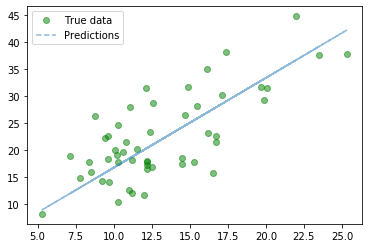

In [102]:
with torch.no_grad(): # Don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = lr(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = lr(Variable(torch.from_numpy(x_train))).data.numpy()
    #print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

Compute the R^squared value. Formula taken from this website: https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python#:~:text=corrcoef()%20to%20calculate%20R,matrix%20between%20x%20and%20y%20.

In [123]:
def compute_r_squared(x, y):
    correlation_matrix = np.corrcoef(x.reshape(1, -1), y.reshape(1, -1))
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

In [127]:
r_sq_nnlr = compute_r_squared(predicted, y_train)
r_sq_nnlr

0.5333279539199924

In [128]:
r_sq_sklr

0.5333279627871967

# Conclusion:

SKLearn and this simple NN acheive similar results! SKLearn is both easier to use and faster but the custom-made NN has more flexibility.